# Programming assignment 2: KNN classifier

In this programming exercise, we will build a KNN classifier and apply it to a handwritten digit dataset (MNIST). Please download the datasets from Canvas and put them in the same folder of this iPython notebook.

Instructions for submission: please submit the following:
* Completed iPython notebook. We will inspect the code and run your notebook.
* Solutions to the corresponding problems




## 1. The MNIST dataset

`MNIST` is a classic database of handwritten digits that is commonly used for training various image processing systems. The MNIST database contains 60,000 training images and 10,000 testing images. In this notebook we will work with a subset of this data: a training set of 2,000 images and a test set of 500 images. Each image is given by 28 X 28 grayscale pixels.

First, let's first load the dataset check the basic statistics.


In [1]:
%matplotlib inline
import numpy as np
import numpy.linalg as la
from scipy.spatial import distance
import operator
import matplotlib.pyplot as plt 
import time
import random
import math
from progressbar import ProgressBar

In [2]:
## Load the training set
# To speed up computation, we will just consider 2000 images for training and 500 images for testing
num_trn, num_tst = 2000,500
train_data = np.load('mnist_train_data.npy')[:num_trn,]
train_labels = np.load('mnist_train_labels.npy')[:num_trn]

## Load the testing set
test_data = np.load('mnist_test_data.npy')[:num_tst,]
test_labels = np.load('mnist_test_labels.npy')[:num_tst]


## Print out their dimensions
print("Training dataset dimensions: ", np.shape(train_data))
print("Number of training labels: ", len(train_labels))
print("Testing dataset dimensions: ", np.shape(test_data))
print("Number of testing labels: ", len(test_labels))

## Compute the number of examples of each digit
train_digits, train_counts = np.unique(train_labels, return_counts=True)
print("Training set distribution:")
print(dict(zip(train_digits, train_counts)))

test_digits, test_counts = np.unique(test_labels, return_counts=True)
print("Test set distribution:")
print(dict(zip(test_digits, test_counts)))



Training dataset dimensions:  (2000, 784)
Number of training labels:  2000
Testing dataset dimensions:  (500, 784)
Number of testing labels:  500
Training set distribution:
{0: 204, 1: 219, 2: 200, 3: 209, 4: 186, 5: 194, 6: 189, 7: 200, 8: 214, 9: 185}
Test set distribution:
{0: 49, 1: 53, 2: 63, 3: 42, 4: 49, 5: 43, 6: 42, 7: 56, 8: 48, 9: 55}


Now, let's randomly choose 10 images from the training dataset and visualize them.

[70, 1173, 1259, 805, 1886, 1313, 1302, 593, 880, 1742]


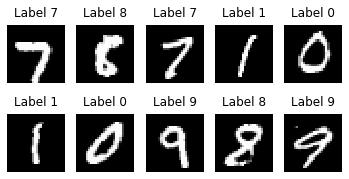

In [3]:
nrows, ncols = 2, 5
index = random.sample(range(len(train_labels)), 10)
print(index)
fig, axes = plt.subplots(nrows, ncols, figsize=(6, 3))
for i in range(nrows):
    for j in range(ncols):
        # Image index
        k = j + i * ncols
        ax = axes[i, j]
        ax.matshow((train_data[index[k],]).reshape((28,28)),cmap=plt.cm.gray)
        ax.set_axis_off()
        ax.set_title("Label " + str(train_labels[index[k]]))

## 2. KNN based on Euclidean distance

Let's first experiment with _Euclidean distance_: for two vectors $x, y \in \mathbb{R}^d$, their Euclidean distance is defined as 
$$\|x - y\| = \sqrt{\sum_{i=1}^d (x_i - y_i)^2}.$$
**Task P1:** Complete the following code section to calculate this distance. Copy the corresponding code to the problem set 1 solution pdf file.

In [4]:
## Computes squared Euclidean distance between two vectors.
def eucl_dist(x,y):
    # input:
    # x, y: vectorization of an image
    # output:
    # the euclidean distance between the two vectors
    
    ### STUDENT: YOUR CODE HERE
    dist = la.norm(x-y)
    return dist
    ### CODE ENDS

Now, let's try to compute the distance between some randomly chosen images.

In [5]:
index = random.sample(range(len(train_labels)), 10)
for i in range(5):
    # Image index
    k = i * 2
    print("Distance from "+str(train_labels[index[k]])+" to "+str(train_labels[index[k+1]])+": "+
          str(eucl_dist(train_data[index[k],],train_data[index[k+1],])))

Distance from 1 to 2: 2629.9539
Distance from 5 to 7: 2220.7302
Distance from 1 to 0: 2904.7527
Distance from 5 to 8: 2109.1145
Distance from 0 to 4: 2567.6965


Now, let's implement the K-nearest neighbor classification. 

**Task P2:** Complete the following code sections for `find_KNN` and `KNN_classifier`. Copy the corresponding code to the problem set 1 solution pdf file.

In [6]:
# Take a vector x and returns the indices of its K nearest neighbors in the training set: train_data
def find_KNN(x, train_data, train_labels, K, dist=eucl_dist):
    # Input: 
    # x: test point
    # train_data: training data X
    # train_labels: training data labels y
    # K: number of nearest neighbors considered
    # dist: default to be the eucl_dist that you have defined above
    # Output:
    # The indices of the K nearest neighbors to test point x in the training set
    
    ##### STUDENT: Your code here #####
    distances = []
    for i in range(len(train_data)):
        distances.append( (i, dist(x, train_data[i]) ) )
    
    distances.sort(key = operator.itemgetter(1))
    return [index[0] for index in distances[0:K]]
        
    ##### END OF CODE #####

Now, you should make use of the `find_KKN` function to define the KNN classifier.

In [7]:
# KNN classification
def KNN_classifier(x, train_data, train_labels,K,dist=eucl_dist):
    # Input:
    # x: test point
    # train_data: training data X
    # train_labels: training data labels y
    # K: number of nearest neighbors considered
    # dist: default to be the eucl_dist that you have defined above
    # Output:
    # the predicted label of the test point
    
    ##### STUDENT: Your code here #####
    
    #get list of K nearest index values and their distances
    label_sums = [0] * 10
    KNN = find_KNN(x, train_data, train_labels, K, dist)
    for neighbor in KNN:
        label_sums[train_labels[neighbor]] += 1
    label_approximation = 0
    for i in range(1, 10):
        if label_sums[i] >= label_sums[label_approximation]:
            label_approximation = i
    #print(label_approximation)
    return label_approximation
    ##### END OF CODE #####

Now, let's examine how the code works for 1-NN (i.e., with K=1).

In [8]:
## Define a function that takes an index into a particular data set ("train" or "test") and displays that image.
def vis_image(index, dataset="train"):
    plt.axis('off')
    if(dataset=="train"): 
        plt.imshow((train_data[index]).reshape((28,28)), cmap=plt.cm.gray)
        label = train_labels[index]
    else:
        plt.imshow((test_data[index]).reshape((28,28)), cmap=plt.cm.gray)
        label = test_labels[index]
    plt.show()
    print("Label " + str(label))
    return

**Task P3: Find one example of success case and one example of failed case for 1-NN. Print the outputs and copy them to the problem set solution file.**

A success case:
1-NN classification:  2
True label:  2
The test image:


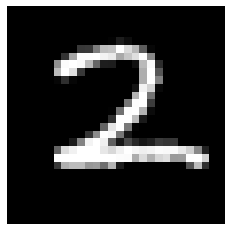

Label 2
The corresponding nearest neighbor image:


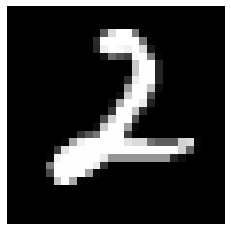

Label 2
A failure case:
NN classification:  9
True label:  3
The test image:


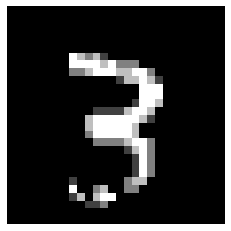

Label 3
The corresponding nearest neighbor image:


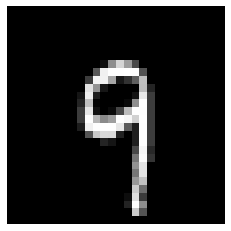

Label 9


In [9]:
## A success case:

ind_success =  45

print("A success case:")
print("1-NN classification: ", KNN_classifier(test_data[ind_success,],train_data,train_labels,1,eucl_dist))
print("True label: ", test_labels[ind_success])
print("The test image:")
vis_image(ind_success, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_KNN(test_data[ind_success,],train_data,train_labels,1,eucl_dist)[0], "train")

## A failure case:
ind_fail =  24
print("A failure case:")
print("NN classification: ", KNN_classifier(test_data[ind_fail,],train_data,train_labels,1,eucl_dist))
print("True label: ", test_labels[ind_fail])
print("The test image:")
vis_image(ind_fail, "test")
print("The corresponding nearest neighbor image:")
vis_image(find_KNN(test_data[ind_fail,],train_data,train_labels,1,eucl_dist)[0], "train")


Now let's apply our K-nearest neighbor classifier over the full data set with `K=3`. 

Note that to classify each test point, our code takes a full pass over each of the 2000 training examples. The following code takes about 8 seconds on 3.3 GHz Intel Core i. 

**Task P4: Report the outputs of the following code and copy them to the problem set solution file.**

In [10]:
## Predict on each test data point (and time it!)
pbar = ProgressBar() # to show progress
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,3,eucl_dist)
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with Euclidean distance: ", error)
print("Classification time (seconds) with Euclidean distance: ", t_after - t_before)

Error of nearest neighbor classifier with Euclidean distance:  0.074
Classification time (seconds) with Euclidean distance:  10.194245100021362


## 3. Different distance metrics

So far, we have been using the Euclidean distance. In this section, let's try the Manhattan distance. You will also design a distance function and report the results.

Recall that the Manhattan distance (a.k.a. $\ell_1$-norm) is given by:
$$\|x - y\|_1 = {\sum_{i=1}^d |x_i - y_i|}.$$

**Task P5: Complete the definition of `manh_dist` and report the outputs of the following code and copy them to the problem set solution file.**

In [11]:
## Computes Manhattan distance between two vectors.
def manh_dist(x,y):
    # input:
    # x, y: vectorization of an image of size 28 by 28
    # output:
    # the distance between the two vectors
    
    ### STUDENT: YOUR CODE HERE
    #dist = cdist(x, y, metric='cityblock')
    dist = np.sum(np.abs(x-y))
    return dist
    ### CODE ENDS

pbar = ProgressBar() # to show progress
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,3,manh_dist)
    
t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with Manhattan distance: ", error)
print("Classification time (seconds) with Manhattan distance: ", t_after - t_before)

Error of nearest neighbor classifier with Manhattan distance:  0.082
Classification time (seconds) with Manhattan distance:  9.77002501487732


**Task P6: Define your own distance function and write down the mathematical definition. Copy the code and the result to the problem set solution file. (2 bonus point) Can you improve over the Euclidean distance?**

My Distance function is modeled after the Minkowski distance formula where p is 3 is given by:
$$\|x - y\|_3 = {\sum_{i=1}^d |x_i - y_i|^3}.$$

In [12]:
## Compute a distance metric of your design
def my_dist(x,y):
    # input:
    # x, y: vectorization of an image of size 28 by 28 
    # output:
    # the distance between the two vectors
    
    ### STUDENT: YOUR CODE HERE
    diff = np.abs(x-y)
    return np.sum(diff**3)
    ### CODE ENDS


In [13]:
pbar = ProgressBar() # to show progress
## Predict on each test data point (and time it!)
t_before = time.time()
test_predictions = np.zeros(len(test_labels))
for i in pbar(range(len(test_labels))):   
    test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,3,my_dist)

t_after = time.time()

## Compute the error
err_positions = np.not_equal(test_predictions, test_labels)
error = float(np.sum(err_positions))/len(test_labels)

print("Error of nearest neighbor classifier with the new distance: ", error)
print("Classification time (seconds) with the new distance: ", t_after - t_before)

Error of nearest neighbor classifier with the new distance:  0.072
Classification time (seconds) with the new distance:  21.141416311264038


## 4. Cross-validation to select K

k-Fold Cross Validation (don't confuse this k with the K in KNN!) is a very useful technique to check how well a model performs when we apply it on an independent data. It is often used to flag problems caused by overfitting and selection bias. However, it brings an additional data processing load and time.

<img style="width:500px" src="K-fold-CV.png">

**Task P7: Implement the 5-fold cross validation to choose the best K (number of nearest neighbors) between 1 and 10 for KNN with Euclidean distance. Copy the code in the solution file and plot the 5-fold validation error with respect to K. Also plot the test error on the same figure. What do you observe?**

In [14]:
### STUDENT: YOUR CODE HERE
test_predictions = np.zeros(len(test_labels))
test_error = np.zeros(10)
training_error = np.zeros(10)
k_fold_predictions = np.zeros(400)

pbar = ProgressBar() # to show progress

for K in pbar(range(1, 11)):
    # calculating test error for all values of K in the range {1, 10}
    for i in range(len(test_labels)):
        test_predictions[i] = KNN_classifier(test_data[i,],train_data,train_labels,K,eucl_dist)
    err_positions = np.not_equal(test_predictions, test_labels)
    test_error[K-1] = float(np.sum(err_positions))/len(test_labels)
    
    # 5-fold cross validation on 2000 training data points
    for k in range(0, 2000, 400):
        k_fold_test_data = train_data[k:k+400]
        k_fold_test_labels = train_labels[k:k+400]
        k_fold_train_data = np.concatenate([train_data[0:k] , train_data[k + 400:]])
        k_fold_train_labels = np.concatenate([train_labels[0:k] , train_labels[k + 400:]])
        
        # perform evaluation over one fold
        for j in range(400):
            k_fold_predictions[j] = KNN_classifier(k_fold_test_data[j,],k_fold_train_data,k_fold_train_labels,K,eucl_dist)
        k_err_positions = np.not_equal(k_fold_predictions, k_fold_test_labels)
        training_error[K-1] += float(np.sum(k_err_positions))/len(k_fold_test_labels)
    # divide sum of errors by 5 for average
    training_error[K-1] /= 5


100% |########################################################################|


<function matplotlib.pyplot.show(*args, **kw)>

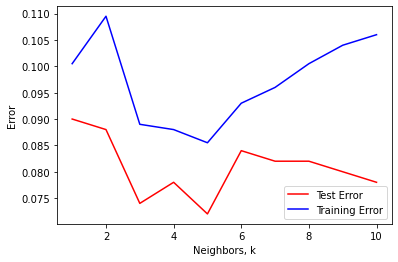

In [15]:
index = np.arange(1, 11)
plt.plot(index, test_error, 'r', label='Test Error')
plt.plot(index, training_error, 'b', label ='Training Error')
plt.legend(loc='best')
plt.xlabel('Neighbors, k')
plt.ylabel('Error')
plt.show

## Conclusion
Based on the 5-fold cross validation or the test error, the best choice is K=5.

Congratulations! You have just implemented the KNN algorithm and tested it on the MNIST dataset!